# Setting up a DASK cluster using dask-jobqueue

Most HPC systems use a batch scheduler (SLURM, PBS,...) to manage multiple users need for computational ressources. We show here
how to deploy a DASK cluster on compute nodes using the SLURM scheduler.

This example is most relevant for GFDL users running on PP/AN. Other HPC users should adapt to match their system specifications
(e.g. batch scheduler, queue name,...). The dask_jobqueue package supports most batch schedulers.

In [1]:
# get the plot in notebook
%matplotlib inline

In [2]:
import xarray as xr

First import the DASK client, this is going to be our interface to see what happens on the DASK cluster

In [3]:
from dask.distributed import Client

**dask_jobqueue.SLURMcluster** is going to allow us to submit a job to our scheduler to create the DASK cluster.
That cluster is going to handle all the computational heavy lifting on the compute nodes and then return the results to the notebook, which is running on a login node.

In [4]:
from dask_jobqueue import SLURMCluster

**Setting up the dashboard (optional):** If you want to be able to follow the progress of the dask cluster, you need to specify a port for the dashboard and create a LocalForward rule in your local machine **.ssh/config** such as: *LocalForward portdash localhost:portdash* The port I choose here depends on my user id.

In [5]:
import subprocess as sp
uid = int( sp.check_output('id -u', shell=True).decode('utf-8').replace('\n','') )
portdash = 10000 + uid

We can now define the queue options (queue name, project id, ressources,...) we want to use for the DASK cluster:

In [6]:
cluster = SLURMCluster(queue='analysis', cores=4, project='gfdl_o', 
                       memory="24GB", walltime="00:30:00",
                       dashboard_address=f':{portdash}')

and then submit the job to the scheduler with the number of **nodes** (here 2) requested:

In [7]:
cluster.scale(2)

Now squeue will show you something like:

```
       NAME       QOS    STATE       TIME TIME_LIMI  NODES      JOBID                 USER
       
dask-worker  windfall  RUNNING       1:26     30:00      1    2222842       Raphael.Dussin

dask-worker  windfall  RUNNING       1:26     30:00      1    2222843       Raphael.Dussin
```

Finally we connect the client (the notebook) to the DASK cluster so we can use the cluster for our compute
and exposing the client will give us the url to access the dashboard:

In [8]:
client = Client(cluster)

In [9]:
client

Client Scheduler: tcp://140.208.147.174:37386 Dashboard: http://140.208.147.174:30476/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Click on dashboard link. Since the IP of PP/AN is behind the firewall, nothing is showing up.
Since we have set a port forwarding rule, we simply replace the IP by localhost 
in the address bar and we now see the dashboard. This is how you do it but what about kicking the tires a little bit?

## Your DASK cluster at work

Open a dataset with xarray, this one lives on the /data_cmip6 volume (accessible on PP/AN only) but this part works for any dataset. Quick explanation of options: open_mfdataset allows to open multiple files and combine into a single dataset following
the coordinates. Since we defined chunks in the argument, xarray will automatically enable DASK under the hood.

In [10]:
datadir = '/data_cmip6/CMIP6/OMIP/NOAA-GFDL/GFDL-CM4/omip1/r1i1p1f1/Omon/thetao/gr/v20180701/'
ds = xr.open_mfdataset(datadir + '*.nc', chunks={'time': 1}, combine='by_coords')

Compute the time average: this is done lazyly so it is very quick. At this point no computations have been performed.

In [11]:
temp_mean = ds['thetao'].mean(dim=['time'])

But we can examine the metadata of the resulting operations and make subsets,...

In [12]:
temp_mean.sel(lev=2.5)

<xarray.DataArray 'thetao' (lat: 180, lon: 360)>
dask.array<shape=(180, 360), dtype=float32, chunksize=(180, 360)>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    lev      float64 2.5

When we ask for numerical values or a plot, this will trigger the computation. Now is a good time to check out that DASK dashboard ;)

CPU times: user 29 s, sys: 1.82 s, total: 30.8 s
Wall time: 2min 14s


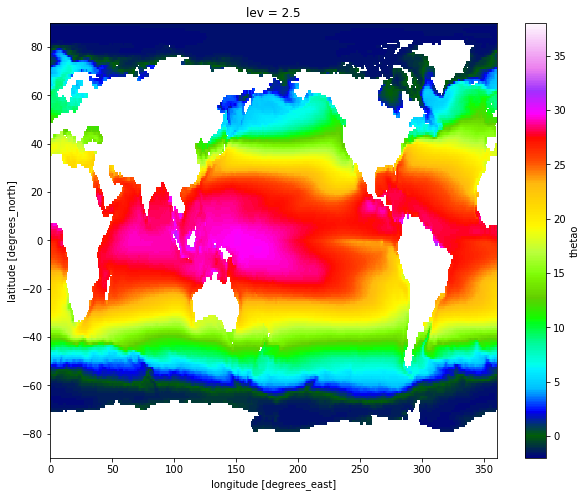

In [13]:
%time temp_mean.sel(lev=2.5).plot(figsize=[10, 8], vmin=-2, vmax=38, cmap='gist_ncar')

once finished, released the nodes by shutting down the cluster and shut down client. Otherwise your SLURM job will still be active and sitting idle until it times out.

In [14]:
cluster.close()
client.close()